# MLA - Uebung 2
Gerald Ebmer, e01325683

# Problem 2.1

## 2.1.1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv')

def sigmoid(w, x):
    return 1/(1+np.exp(-np.dot(w.flatten(),x.flatten())))

def sample_loss(w,x,y, l=0):
    y_hat = sigmoid(w,x)
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)) + l*np.sum(w**2)

def batch_loss(w, X, y, l=0):
    return np.mean([sample_loss(w, x, y, l) for x,y in zip(X,y)])


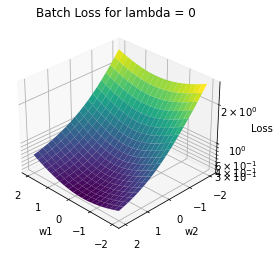

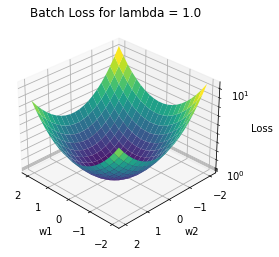

In [2]:
# plot loss over data
def plot_loss(x,y, w_lim, l=0):
    
    w1_values = np.linspace(-w_lim, w_lim, 20)
    w2_values = np.linspace(-w_lim, w_lim, 20)
    w1_mesh, w2_mesh = np.meshgrid(w1_values, w2_values)
    loss_values = np.zeros_like(w1_mesh)

    # Calculate loss for each combination of w1 and w2
    for i in range(len(w1_values)):
        for j in range(len(w2_values)):
            w = np.array([w1_values[i], w2_values[j]])
            loss_values[i, j] = batch_loss(w, x, y, l)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the loss as a surface
    surface = ax.plot_surface(w1_mesh, w2_mesh, loss_values, cmap='viridis')
    ax.view_init(elev=30, azim=135)  
    ax.set_zscale('log')
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('Loss')
    ax.set_title('Batch Loss for lambda = {}'.format(l))

x = np.stack([np.array(data['x0']), np.array(data['x1'])], axis=1)
y = np.array(data['y'])

plot_loss(x, y, w_lim=2, l=0)
plot_loss(x, y, w_lim=2, l=1e0)



## 2.1.2 Analytic Gradient

$ \nabla_w L = (\hat{y}_i - y_i) \vec{x} - \lambda \vec{w}$

In [3]:
def grad_w(w, x, y, l=0):
    y_hat = sigmoid(w,x)
    return (y_hat - y)*x - l*w

# test gradient
w_ = np.array([1,2])
x_ = np.array([1,2])
y_ = 0
print("grad: {}".format(grad_w(w_,x_,y_, l=0)))

grad: [0.99330715 1.9866143 ]


## 2.1.3 Batch Gradient Descent

In [4]:
def batch_gradient_descent(w, x, y, alpha=0.1, l=0):
    loss = batch_loss(w, x, y, l)
    w = w - alpha * np.mean([grad_w(w, x, y, l) for x,y in zip(x,y)], axis=0)
    return w, loss

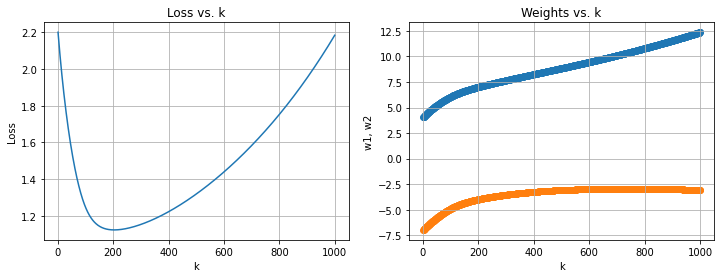

In [5]:
w_list = []
loss_list = []
w = np.array([4,-7])
k = np.arange(1, 1001)
for i in k:
    w, loss = batch_gradient_descent(w, x, y, alpha=0.1, l=1e-2)
    w_list.append(w)
    loss_list.append(loss)

# first subplot loss vs k, second subplot scatter plot of weights over k 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(k,loss_list)
ax1.set_xlabel('k')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs. k')
ax1.grid()
ax2.scatter(k, [w[0] for w in w_list])
ax2.scatter(k, [ w[1] for w in w_list])
ax2.set_xlabel('k')
ax2.set_ylabel('w1, w2')
ax2.set_title('Weights vs. k')
ax2.grid()
plt.show()


Optimizes but stop criteria is missing. Moves away from optimal w at some point.

## 2.1.4 Stochastic Gradient Descent

In [6]:
def stochastic_gradient_descent(w, x, y, alpha=0.1, l=0):
    loss = sample_loss(w, x, y, l)
    w = w - alpha * grad_w(w, x, y, l)
    return w, loss

data length: 100


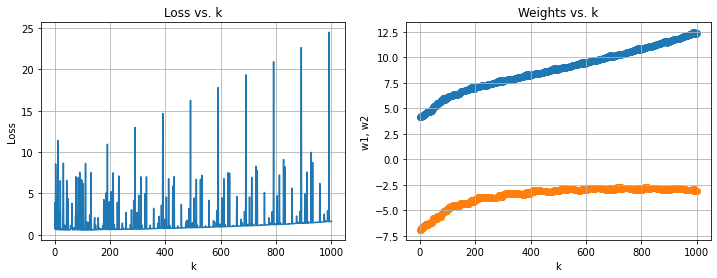

In [7]:
# stochastic gradient descent
w_list = []
loss_list = []
w = np.array([4,-7])
k = np.arange(1, 1001)

data_len = len(x)
print("data length: {}".format(data_len))

for i in k:
    w, loss = stochastic_gradient_descent(w, x[i%len(x)], y[i%len(x)], alpha=0.1, l=1e-2)
    w_list.append(w)
    loss_list.append(loss)

# first subplot loss vs k, second subplot scatter plot of weights over k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(k,loss_list)
ax1.set_xlabel('k')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs. k')
ax1.grid()
ax2.scatter(k, [w[0] for w in w_list])
ax2.scatter(k, [ w[1] for w in w_list])
ax2.set_xlabel('k')
ax2.set_ylabel('w1, w2')
ax2.set_title('Weights vs. k')
ax2.grid()
plt.show()


SGD better for large data sets. Epochs > datpoints to traverse whole data at least once. SGD is noisier than BGD. BGD has smoother convergence properties.

## 2.1.5 Tensorflow - Auto Diff / GradientTape API

In [8]:
import tensorflow as tf
import numpy as np

def sigmoid_tf(w, x):
    return 1 / (1 + tf.exp(-tf.linalg.matmul(tf.transpose(w), x)))

def custom_loss(w, x, y, l=0):
    y_hat = sigmoid_tf(w, x)
    loss = -(y * tf.math.log(y_hat) + (1 - y) * tf.math.log(1 - y_hat)) + l * tf.reduce_sum(w ** 2)
    return tf.reduce_sum(loss)

def grad_w_tf(w, x, y, l=0):
    with tf.GradientTape() as tape:
        y_hat = sigmoid_tf(w, x)
        loss = custom_loss(w,x,y,l) 
    gradients = tape.gradient(loss, w)
    return gradients

# Example data
x = np.random.randn(2, 1).astype(np.float32)  # Sample input as a 2x1 matrix
y = np.random.randn(2)  # Sample label
w = tf.Variable(np.random.randn(2, 1).astype(np.float32), dtype=tf.float32)  # Initializing weights as a 2x1 matrix

print("x.shape: {}".format(x.shape))
print("y.shape: {}".format(y.shape))
print("w.shape: {}".format(w.shape))
gradients = grad_w_tf(w, x, y, l=0)
print(gradients)



x.shape: (2, 1)
y.shape: (2,)
w.shape: (2, 1)
tf.Tensor(
[[-1.0107284]
 [ 0.5971342]], shape=(2, 1), dtype=float32)


In [11]:
# compare grad and grad_w
w_ = np.array([1,2]).reshape(2,1)
x_ = np.array([1,2]).reshape(2,1)
y_ = np.array([0])
my_grad = grad_w(w_,x_,y_, l=0)

print("grad: {}".format(my_grad))
w = tf.Variable(w_, dtype=tf.float32)  # Initializing weights as a 2x1 matrix
tf_grad = grad_w_tf(w, x_, y_, l=0)
print("grad_w: {}".format(grad_w_tf(w,x_,y_, l=0)))
delta_grad = my_grad - tf_grad
print("delta_grad: {}".format(delta_grad))


grad: [[0.99330715]
 [1.9866143 ]]
grad_w: [[0.9933107]
 [1.9866214]]
delta_grad: [[-3.516674e-06]
 [-7.033348e-06]]


Both gradient computations match!

# 

# Problem 2.2

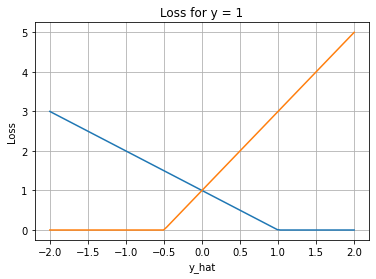

In [16]:
def svc_loss(w, b, x, y, l=0):
    y_hat = x.transpose() @ w + b
    return np.mean(np.maximum(0, 1 - y * y_hat) + l * np.sum(w ** 2))

def svc_loss2(y_hat, y, l=0):
    w = 0
    return np.mean(np.maximum(0, 1 - y * y_hat) + l * np.sum(w ** 2))


# plot svc_loss2 with y = 1 over y_hat
y_hat = np.linspace(-2, 2, 100)
loss_values = np.zeros_like(y_hat)
loss_values2 = np.zeros_like(y_hat)
for i in range(len(y_hat)):
    loss_values[i] = svc_loss2(y_hat[i], y=1, l=0)
    loss_values2[i] = svc_loss2(y_hat[i], y=-2, l=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_hat, loss_values, label='y = 1')
ax.plot(y_hat, loss_values2, label='y = -1')
ax.set_xlabel('y_hat')
ax.set_ylabel('Loss')
ax.set_title('Loss for y = 1')
ax.grid()
plt.show()


Perceptron had smoother transition.

## 2.2.2 SVC with linear kernel and C = 1

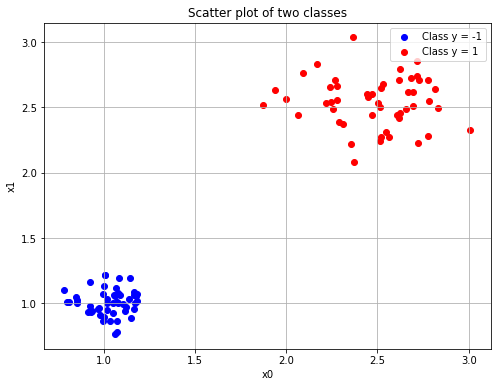

Weights (w): [0.89418064 1.01994712]
Bias (b): -3.241488064209292


In [21]:
from sklearn.svm import SVC

data = pd.read_csv('blobs.csv')

x = np.stack([np.array(data['x_0']), np.array(data['x_1'])], axis=1)
y = np.array(data['y'])

# Scatter plot to visualize the classes
plt.figure(figsize=(8, 6))
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], label='Class y = -1', c='blue')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], label='Class y = 1', c='red')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Scatter plot of two classes')
plt.legend()
plt.grid()
plt.show()

# Fit SVC with linear kernel and C=1
clf = SVC(kernel='linear', C=1)
clf.fit(x, y)

# Extract weights and bias from the trained model
weights = clf.coef_[0]
bias = clf.intercept_[0]

print("Weights (w):", weights)
print("Bias (b):", bias)


## 2.2.3 Add Hyperplane

Margin distance: 1.4744792005954694


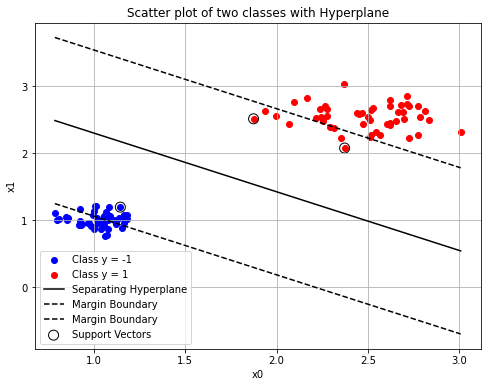

In [24]:
# Scatter plot to visualize the classes
plt.figure(figsize=(8, 6))
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], label='Class y = -1', c='blue')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], label='Class y = 1', c='red')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Scatter plot of two classes with Hyperplane')


# Plotting the separating hyperplane
xx = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
yy = (-bias - weights[0] * xx) / weights[1]

plt.plot(xx, yy, 'k-', label='Separating Hyperplane')

# Calculate margin distance
support_vectors = clf.support_vectors_
distances = clf.decision_function(support_vectors)
margin_distance = 2 / np.linalg.norm(weights)

print("Margin distance:", margin_distance)

# Plotting margin boundaries
yy_down = yy - np.sqrt(1 + np.dot(weights, weights)) / np.linalg.norm(weights)
yy_up = yy + np.sqrt(1 + np.dot(weights, weights)) / np.linalg.norm(weights)

plt.plot(xx, yy_down, 'k--', label='Margin Boundary')
plt.plot(xx, yy_up, 'k--', label='Margin Boundary')

# Plot support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='black', label='Support Vectors')
plt.legend()
plt.grid()
plt.show()


TODO: derive margin distance

## 2.2.4 Same but with Circles

Margin distance: 1.4744792005954694


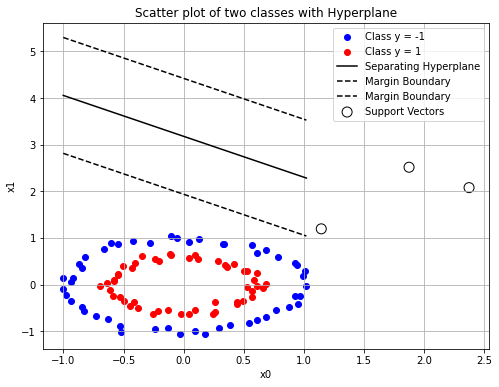

In [25]:
data = pd.read_csv('circles.csv')

x = np.stack([np.array(data['x_0']), np.array(data['x_1'])], axis=1)
y = np.array(data['y'])

# Scatter plot to visualize the classes
plt.figure(figsize=(8, 6))
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], label='Class y = -1', c='blue')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], label='Class y = 1', c='red')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Scatter plot of two classes with Hyperplane')

# Fit SVC with linear kernel and C=1
clf = SVC(kernel='linear', C=1)
clf.fit(x, y)

# Extract weights and bias from the trained model
weights = clf.coef_[0]
bias = clf.intercept_[0]

# Plotting the separating hyperplane
xx = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
yy = (-bias - weights[0] * xx) / weights[1]

plt.plot(xx, yy, 'k-', label='Separating Hyperplane')

# Calculate margin distance
support_vectors = clf.support_vectors_
distances = clf.decision_function(support_vectors)
margin_distance = 2 / np.linalg.norm(weights)

print("Margin distance:", margin_distance)

# Plotting margin boundaries
yy_down = yy - np.sqrt(1 + np.dot(weights, weights)) / np.linalg.norm(weights)
yy_up = yy + np.sqrt(1 + np.dot(weights, weights)) / np.linalg.norm(weights)

plt.plot(xx, yy_down, 'k--', label='Margin Boundary')
plt.plot(xx, yy_up, 'k--', label='Margin Boundary')

# Plot support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='black', label='Support Vectors')
plt.legend()
plt.grid()
plt.show()
